# CIFAR-10 vs. CIFAR-100 Outlier Exposure Experiment

## Imports

In [1]:
# append source path
import sys
sys.path.append('/Users/lukasruff/Repos/Deep-SAD-PyTorch-dev/src')

In [2]:
# check working directory
import os
cwd = os.getcwd()
print(cwd)

/Users/lukasruff/Repos/ClassAD/notebooks


In [3]:
# imports
import json
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

sns.set()
plt.style.use('seaborn-whitegrid')
# sns.set_style("white")
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.9)

mpl.rcParams['mathtext.fontset'] = 'cm'

%matplotlib inline

## Data Loading

In [4]:
import json

results = {
    'AUC': [],
    'Method': [],
    'k': [],
    'class': [],
}

root = '/Users/lukasruff/Repos/Deep-SAD-PyTorch-dev/log/20200129'
output_file = 'auc_cifar100_oe.json'

method_paths = ['compact_classifier/cifar10/oe_cifar100/l2_squared_linear',
                'compact_classifier_swapped/cifar10/oe_cifar100/l2_squared_linear',
                'baselines/classifier/cifar10/oe_cifar100/LeNet']
method_names = ['CC regular', 'CC swapped', 'BCE']
oe_classes = [1, 2, 4, 8, 16, 32, 64, 100]
exps = range(10)
seeds = range(1, 11)

for i, method_path in enumerate(method_paths):
    
    for k in oe_classes:
        k_folder = str(k) + '_oe_classes'
        
        for exp in exps:
            exp_folder = str(exp) + 'vsall'
            
            for seed in seeds:
                file_name = 'results.json'
                exp_path = root + '/' + method_path + '/' + k_folder + '/' + exp_folder + '/seed_' + str(seed)
                file_path = exp_path + '/' + file_name
                
                if os.path.exists(file_path):
                    with open(file_path, 'r') as fp:
                        result = json.load(fp)
                        results['AUC'].append(result['test_auc'])
                        results['Method'].append(method_names[i])
                        results['k'].append(k)
                        results['class'].append(exp)
                            
                else:
                    print(file_path)
                    results['AUC'].append(np.nan)
                    results['Method'].append(method_names[i])
                    results['k'].append(k)
                    results['class'].append(exp)

# Save results dict to a JSON-file
json_file = root + '/' + output_file
with open(json_file, 'w') as fp:
    json.dump(results, fp)
    
df = pd.DataFrame(results, columns=['AUC', 'Method', 'k', 'class'])

In [5]:
df.isna().sum()

AUC       0
Method    0
k         0
class     0
dtype: int64

In [6]:
len(df)

2400

In [7]:
mean_results = {
    'AUC': [],
    'std': [],
    'Method': [],
    'k': [],
    'class': [],
}

for i in method_names:
    for k in oe_classes:
        for exp in exps:
            aucs = df[(df['Method'] == i) & (df['k'] == k) & (df['class'] == exp)].AUC
            mean = np.nanmean(aucs)
            std = np.nanstd(aucs)
            mean_results['AUC'].append(float(mean))
            mean_results['std'].append(float(std))
            mean_results['Method'].append(i)
            mean_results['k'].append(k)
            mean_results['class'].append(exp)

mean_df = pd.DataFrame(results, columns=['AUC', 'std', 'Method', 'k', 'class'])
            
# Save results dict to a JSON-file
json_file = root + '/mean_auc_cifar100_oe.json'
with open(json_file, 'w') as fp:
    json.dump(mean_results, fp)

## Plots

In [8]:
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

markers = ["o", "s", "x"]

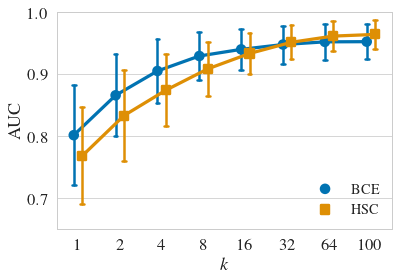

In [9]:
# plot avg. over one-class experiments

f, ax = plt.subplots()

sns.pointplot(x='k', 
              y='AUC', 
              hue='Method', 
              # data=df, 
              data=mean_df, 
              hue_order=['BCE', 'CC regular'], 
              ci='sd', 
              join=True, 
              dodge=0.2, 
              markers=markers, 
              errwidth=2.5, 
              capsize=.09, 
              scale=1.5, 
              palette='colorblind', 
              s=60
)

# add title
# plt.title('Avg. over 10 one-class setups')

# add legend
L = ax.legend(loc='lower right', fontsize='x-large')
L.get_texts()[1].set_text(r'$\textrm{HSC}$')
# L.get_texts()[2].set_text(r'$\textrm{HSC}_{S}$')

# format axis
ax.set_ylim(0.65, 1.0)
ax.set_xlabel(r'$k$')
ax.set_ylabel('AUC')
ax.set_yticks([0.7, 0.8, 0.9, 1.0], minor=False)
ax.set_yticks([0.75, 0.85, 0.95], minor=True)
ax.yaxis.grid(True, which='major')
# ax.yaxis.grid(True, which='minor')

In [10]:
# Save figure
f.savefig(root + '/auc_cifar100_oe_avg.pdf', bbox_inches='tight')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [11]:
# plot results for each one-class experiments

for exp in exps:
    
    f, ax = plt.subplots()

    sns.pointplot(x='k', 
                  y='AUC', 
                  hue='Method', 
                  data=df.loc[df['class'] == exp], 
                  hue_order=['BCE', 'CC regular'], 
                  ci='sd', 
                  join=True, 
                  dodge=0.2, 
                  markers=markers, 
                  errwidth=2.5, 
                  capsize=.09, 
                  scale=1.5, 
                  palette='colorblind', 
                  s=60
    )

    # add title
    # plt.title(str(exp) + 'vsall')
    
    # add legend
    L = ax.legend(loc='lower right', fontsize='x-large')
    L.get_texts()[1].set_text(r'$\textrm{HSC}$')
    # L.get_texts()[2].set_text(r'$\textrm{HSC}_{S}$')

    # format axis
    ax.set_xlabel(r'$k$')
    ax.set_ylabel('AUC')
    ax.yaxis.grid(True, which='major')
    
    # Save figure
    f.savefig(root + '/auc_cifar100_oe_' + str(exp) + 'vsall.pdf', bbox_inches='tight')
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>